In [ ]:
# default_exp examples.multilabel_classification

In [ ]:
#all_slow

In [ ]:
#hide
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# examples.multilabel_classification

> This is an example of how to use blurr for multilabel classification tasks

In [ ]:
#export
import torch, nlp
from transformers import *

from fastai.text.all import *
from fastai.callback.hook import _print_shapes

from blurr.utils import *
from blurr.data.core import *
from blurr.modeling.core import *

logging.set_verbosity_error()

In [ ]:
#hide
import pdb

from nbdev.showdoc import *
from fastcore.test import *

from fastai import __version__ as fa_version
from torch import __version__ as pt_version
from transformers import __version__ as hft_version

print(f'Using pytorch {pt_version}')
print(f'Using fastai {fa_version}')
print(f'Using transformers {hft_version}')

Using pytorch 1.7.0
Using fastai 2.1.3
Using transformers 3.4.0


In [ ]:
#cuda
torch.cuda.set_device(1)
print(f'Using GPU #{torch.cuda.current_device()}: {torch.cuda.get_device_name()}')

Using GPU #1: GeForce GTX 1080 Ti


Let's start by building our `DataBlock`

In [ ]:
# creates a dataset with the first 10% of training set
raw_data = nlp.load_dataset('civil_comments', split='train[:1%]') 
len(raw_data)

Using custom data configuration default


18049

In [ ]:
toxic_df = pd.DataFrame(raw_data, columns=list(raw_data.features.keys()))
toxic_df.head()

,text,toxicity,severe_toxicity,obscene,threat,insult,identity_attack,sexual_explicit
0,"This is so cool. It's like, 'would you want your mother to read this??' Really great idea, well done!",0.000000,0.000000,0.0,0.0,0.00000,0.000000,0.0
1,"Thank you!! This would make my life a lot less anxiety-inducing. Keep it up, and don't let anyone get in your way!",0.000000,0.000000,0.0,0.0,0.00000,0.000000,0.0
2,This is such an urgent design problem; kudos to you for taking it on. Very impressive!,0.000000,0.000000,0.0,0.0,0.00000,0.000000,0.0
3,Is this something I'll be able to install on my site? When will you be releasing it?,0.000000,0.000000,0.0,0.0,0.00000,0.000000,0.0
4,haha you guys are a bunch of losers.,0.893617,0.021277,0.0,0.0,0.87234,0.021277,0.0


In [ ]:
lbl_cols = list(toxic_df.columns[2:]); lbl_cols

['severe_toxicity',
 'obscene',
 'threat',
 'insult',
 'identity_attack',
 'sexual_explicit']

In [ ]:
toxic_df = toxic_df.round({col: 0 for col in lbl_cols})
toxic_df = toxic_df.convert_dtypes()

toxic_df.head()

,text,toxicity,severe_toxicity,obscene,threat,insult,identity_attack,sexual_explicit
0,"This is so cool. It's like, 'would you want your mother to read this??' Really great idea, well done!",0.000000,0,0,0,0,0,0
1,"Thank you!! This would make my life a lot less anxiety-inducing. Keep it up, and don't let anyone get in your way!",0.000000,0,0,0,0,0,0
2,This is such an urgent design problem; kudos to you for taking it on. Very impressive!,0.000000,0,0,0,0,0,0
3,Is this something I'll be able to install on my site? When will you be releasing it?,0.000000,0,0,0,0,0,0
4,haha you guys are a bunch of losers.,0.893617,0,0,0,1,0,0


For our huggingface model, let's used the distilled version of RoBERTa. This should allow us to train the model on bigger mini-batches without much performance loss.  Even on my 1080Ti, I should be able to train all the parameters (which isn't possible with the `roberta-base` model)

In [ ]:
task = HF_TASKS_AUTO.SequenceClassification

pretrained_model_name = "distilroberta-base"
config = AutoConfig.from_pretrained(pretrained_model_name)
config.num_labels = len(lbl_cols)

hf_arch, hf_config, hf_tokenizer, hf_model = BLURR_MODEL_HELPER.get_hf_objects(pretrained_model_name, 
                                                                               task=task, 
                                                                               config=config)

print(hf_arch)
print(type(hf_config))
print(type(hf_tokenizer))
print(type(hf_model))

roberta
<class 'transformers.configuration_roberta.RobertaConfig'>
<class 'transformers.tokenization_roberta.RobertaTokenizer'>
<class 'transformers.modeling_roberta.RobertaForSequenceClassification'>


Note how we have to configure the `num_labels` to the number of labels we are predicting. Given that our labels are already encoded, we use a `MultiCategoryBlock` with encoded=True and vocab equal to the columns with our 1's and 0's.

In [ ]:
blocks = (
    HF_TextBlock(hf_arch=hf_arch, hf_tokenizer=hf_tokenizer), 
    MultiCategoryBlock(encoded=True, vocab=lbl_cols)
)

dblock = DataBlock(blocks=blocks, 
                   get_x=ColReader('text'), get_y=ColReader(lbl_cols), 
                   splitter=RandomSplitter())

In [ ]:
dls = dblock.dataloaders(toxic_df, bs=8)

In [ ]:
b = dls.one_batch()
len(b), b[0]['input_ids'].shape, b[1].shape

(2, torch.Size([8, 391]), torch.Size([8, 6]))

With our DataLoaders built, we can now build our `Learner` and train.  We'll use mixed precision so we can train with bigger batches

In [ ]:
model = HF_BaseModelWrapper(hf_model)

learn = Learner(dls, 
                model,
                opt_func=partial(Adam),
                loss_func=BCEWithLogitsLossFlat(),
                metrics=[partial(accuracy_multi, thresh=0.2)],
                cbs=[HF_BaseModelCallback],
                splitter=hf_splitter).to_fp16()

learn.loss_func.thresh = 0.2
learn.create_opt()             # -> will create your layer groups based on your "splitter" function
learn.freeze()

In [ ]:
learn.blurr_summary()

In [ ]:
preds = model(b[0])
preds.logits.shape, preds

(torch.Size([8, 6]),
 SequenceClassifierOutput(loss=None, logits=tensor([[ 0.0107, -0.1214, -0.3061, -0.3257,  0.0964,  0.1850],
         [ 0.0047, -0.1158, -0.3141, -0.3426,  0.0726,  0.1811],
         [ 0.0029, -0.1275, -0.3131, -0.3399,  0.0762,  0.1922],
         [ 0.0064, -0.1411, -0.3199, -0.3310,  0.0916,  0.1928],
         [-0.0010, -0.1238, -0.3144, -0.3337,  0.0911,  0.1863],
         [-0.0027, -0.1311, -0.3200, -0.3239,  0.0695,  0.1824],
         [ 0.0104, -0.1247, -0.3161, -0.3228,  0.0757,  0.1719],
         [-0.0045, -0.1240, -0.3082, -0.3220,  0.0738,  0.1843]],
        device='cuda:1', grad_fn=<AddmmBackward>), hidden_states=None, attentions=None))

SuggestedLRs(lr_min=0.006918309628963471, lr_steep=0.0014454397605732083)

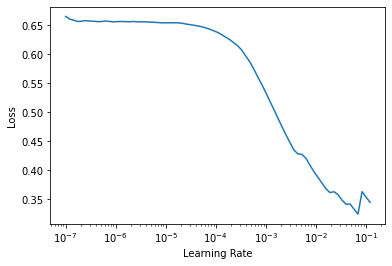

In [ ]:
learn.lr_find(suggestions=True)

In [ ]:
learn.fit_one_cycle(3, lr_max=1e-2)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.096789,0.055679,0.993858,01:31
1,0.045089,0.031949,0.993858,01:33
2,0.038368,0.031585,0.993858,01:32


SuggestedLRs(lr_min=4.786300777936958e-09, lr_steep=1.995262288723154e-11)

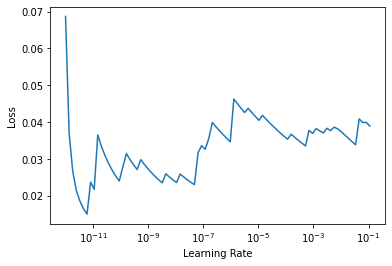

In [ ]:
learn.unfreeze()
learn.lr_find(suggestions=True, start_lr=1e-12)

In [ ]:
learn.fit_one_cycle(5, lr_max=slice(1e-10, 4e-9))

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.035187,0.031585,0.993858,02:41
1,0.038267,0.031585,0.993858,02:42
2,0.023993,0.031585,0.993858,02:43
3,0.036898,0.031585,0.993858,02:44
4,0.035371,0.031585,0.993858,02:44


In [ ]:
learn.show_results(learner=learn, max_n=2)

,text,None,target
0,"Do not so readily suppose that people coming out of PSU are into sustainability, any more than people coming out of Metro. There is a lot of parrot-thinking going on in those chambers, supporting growth as usual dressed as sustainability. \n\nWhat originated in the 60s and 70s as an in-depth, holistic approach to bringing our human populations and consumption down to within the carrying capacity of the local bioregion, through relocalizing our commerce — and thereby achieving prosperity, more greenspaces, and better quality of life for all — has been corrupted into a machination for the haves to have more and the have-nots to get less, and for our neighborhoods to grow more overcrowded and more separated from nature. \n\nWhat originated as a bottom-up process has become a top-down process aided by the ivory tower views of academics and politicos, all congratulating each other on their progressive idealism even as we slide further into unsustainable existence ruled by non-local and elite capitalists.",,[]
1,"Ah me... I've actually written a proposal, enthusiastically adopted by the Jefferson Westside Neighbors, for a (big mouthful) multi-generational, family-friendly, mixed-density (but averaging ""high"") housing project on the old Naval Reserve site on W. 13th Ave., across 14th from Caesar Chavez Elementary. Shot down by Envision Eugene planners and the Planning Commission.\n\nYes, this seems unbelievably stupid, and it was. But they wanted to simply rezone the site to R-2, no plan at all for how it would be developed. That's Envision Eugene - no credible analysis, no real ""plans,"" no genuine involvement of neighborhood folks. Just ""true believers"" who still see the world as ""density versus sprawl.""\n \nI'm not too worried about the Willamette Valley farmland actually being ""covered"" with houses, and that's a straw man. Doing some intelligent development, with mixed densities, in some areas just outside the current UGB could be a good idea. There are also lots of ""opportunity sites"" close in.",insult,[]


In [ ]:
learn.loss_func.thresh = 0.02

In [ ]:
comment = """
Those damned affluent white people should only eat their own food, like cod cakes and boiled potatoes. 
No enchiladas for them!
"""
learn.blurr_predict(comment)

((#1) ['insult'],
 tensor([False, False, False,  True, False, False]),
 tensor([1.4145e-06, 6.0739e-03, 3.5144e-04, 2.7743e-02, 1.3564e-03, 1.3511e-03]))

## Cleanup

In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script()

Converted 00_utils.ipynb.
Converted 01_data-core.ipynb.
Converted 01a_data-token-classification.ipynb.
Converted 01b_data-question-answering.ipynb.
Converted 01e_data-summarization.ipynb.
Converted 01z_data-language-modeling.ipynb.
Converted 02_modeling-core.ipynb.
Converted 02a_modeling-token-classification.ipynb.
Converted 02b_modeling-question-answering.ipynb.
Converted 02e_modeling-summarization.ipynb.
Converted 02z_modeling-language-modeling.ipynb.
Converted 99a_examples_multilabel.ipynb.
Converted index.ipynb.
